In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import winshell

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, jaccard_score, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
base_path = winshell.shortcut(r"G:/My Drive/Thesis/HAM10000.lnk").path

for item in os.listdir(base_path):
    print(item)

HAM10000_metadata.csv
hmnist_28_28_L.csv
hmnist_28_28_RGB.csv
hmnist_8_8_L.csv
hmnist_8_8_RGB.csv
HAM10000_images_part_2
HAM10000_images_part_1


In [3]:
print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.1
Built with CUDA: True
Num GPUs Available:  1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
image_dir_1 = os.path.join(base_path, "HAM10000_images_part_1")
image_dir_2 = os.path.join(base_path, "HAM10000_images_part_2")

images = os.listdir(image_dir_1) + os.listdir(image_dir_2)
print(f"Total images: {len(images)}")

Total images: 10015


In [5]:
df = pd.read_csv(os.path.join(base_path, "HAM10000_metadata.csv"))
print(f"Total entries in metadata: {len(df)}")
df.head()

Total entries in metadata: 10015


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
output = "E:\\Coding\\Thesis"

In [7]:
for split in ["train", "val", "test"]:
    for c in df["dx"].unique():
        os.makedirs(os.path.join(output, split, str(c)), exist_ok=True)

In [8]:
def find_image_path(f):
    path1 = os.path.join(image_dir_1, f + ".jpg")
    path2 = os.path.join(image_dir_2, f + ".jpg")
    if os.path.exists(path1):
        return path1
    elif os.path.exists(path2):
        return path2
    else:
        raise FileNotFoundError(f"{f}.jpg not found in either folder")

In [9]:
for c in df["dx"].unique():
    files = df[df["dx"] == c]["image_id"].tolist()

    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)
    train_files, val_files = train_test_split(train_files, test_size=0.1, random_state=42)
    
    for f in train_files:
        shutil.copy(find_image_path(f), os.path.join(output, "train", str(c), f + ".jpg"))
    for f in val_files:
        shutil.copy(find_image_path(f), os.path.join(output, "val", str(c), f + ".jpg"))
    for f in test_files:
        shutil.copy(find_image_path(f), os.path.join(output, "test", str(c), f + ".jpg"))

In [10]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    os.path.join(output, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(output, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = val_datagen.flow_from_directory(
    os.path.join(output, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

num_classes = train_gen.num_classes

Found 7205 images belonging to 7 classes.
Found 805 images belonging to 7 classes.
Found 2005 images belonging to 7 classes.


In [11]:
base_model = Xception(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = True

optimizer = Adam(learning_rate=1e-4)

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

In [12]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
226/226 [==============================] - 146s 596ms/step - loss: 0.8933 - accuracy: 0.6978 - val_loss: 0.7510 - val_accuracy: 0.7242 - lr: 1.0000e-04
Epoch 2/50
226/226 [==============================] - 62s 273ms/step - loss: 0.5832 - accuracy: 0.7932 - val_loss: 0.6153 - val_accuracy: 0.7764 - lr: 1.0000e-04
Epoch 3/50
226/226 [==============================] - 66s 291ms/step - loss: 0.4726 - accuracy: 0.8314 - val_loss: 0.7399 - val_accuracy: 0.8025 - lr: 1.0000e-04
Epoch 4/50
226/226 [==============================] - 67s 294ms/step - loss: 0.3832 - accuracy: 0.8588 - val_loss: 0.5130 - val_accuracy: 0.8211 - lr: 1.0000e-04
Epoch 5/50
226/226 [==============================] - 72s 316ms/step - loss: 0.3358 - accuracy: 0.8793 - val_loss: 0.4564 - val_accuracy: 0.8410 - lr: 1.0000e-04
Epoch 6/50
226/226 [==============================] - 74s 327ms/step - loss: 0.2793 - accuracy: 0.8978 - val_loss: 0.6023 - val_accuracy: 0.7925 - lr: 1.0000e-04
Epoch 7/50
226/226 [=======

In [13]:
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

unique_classes = np.unique(y_true)
iou_scores = [jaccard_score(y_true == cls, y_pred_classes == cls) for cls in unique_classes]
f1_scores = [f1_score(y_true == cls, y_pred_classes == cls) for cls in unique_classes]

test_acc = accuracy_score(y_true, y_pred_classes)
mean_iou = np.mean(iou_scores)
std_iou = np.std(iou_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print("Mean IoU:", mean_iou)
print("Std IoU:", std_iou)
print("Mean F1:", mean_f1)
print("Std F1:", std_f1)
print("Eval. Score:", test_acc)


63/63 [==============================] - 35s 559ms/step
Mean IoU: 0.6063367044014043
Std IoU: 0.17326346117328928
Mean F1: 0.7408899084413196
Std F1: 0.13055018691198772
Eval. Score: 0.8448877805486285


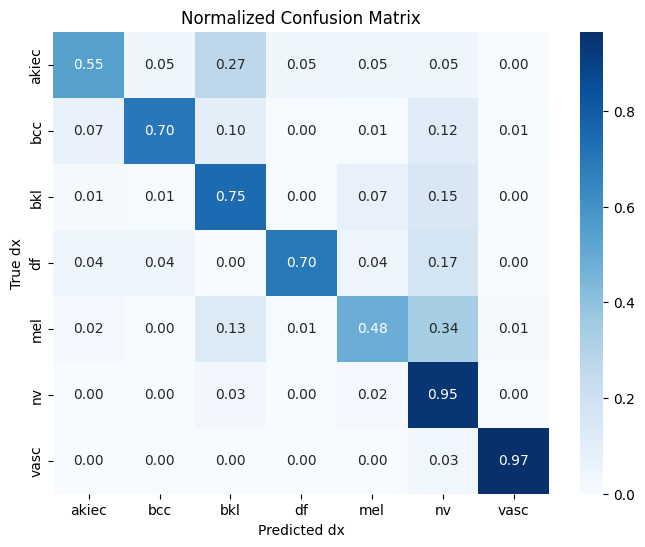

In [14]:
cm = confusion_matrix(y_true, y_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
class_labels = list(test_gen.class_indices.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted dx")
plt.ylabel("True dx")
plt.title("Normalized Confusion Matrix")
plt.show()